<h1><b>Magic Gamma Telescope Dataset</b></h1>
<p>In this notebook, we are going to determine which model can predict whether a signal

In [1]:
#Data manipulation 
import numpy as np
import pandas as pd 

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

#Statistics
from scipy import stats
from scipy.stats import norm 

#Machine Learning
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data_csv = pd.read_csv("magic04.csv")

df = raw_data_csv.copy()

In [3]:
df.head(5)

,length,width,size,conc,conc1,asym,m3long,m3trans,alpha,dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   length   19020 non-null  float64
 1   width    19020 non-null  float64
 2   size     19020 non-null  float64
 3   conc     19020 non-null  float64
 4   conc1    19020 non-null  float64
 5   asym     19020 non-null  float64
 6   m3long   19020 non-null  float64
 7   m3trans  19020 non-null  float64
 8   alpha    19020 non-null  float64
 9   dist     19020 non-null  float64
 10  class    19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [5]:
#The values of each feature are of different scales. We will have to standardize these before feeding the data into our model.

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
length,19020.0,53.250154,42.364855,4.2835,24.336000,37.14770,70.122175,334.1770
width,19020.0,22.180966,18.346056,0.0000,11.863800,17.13990,24.739475,256.3820
size,19020.0,2.825017,0.472599,1.9413,2.477100,2.73960,3.101600,5.3233
conc,19020.0,0.380327,0.182813,0.0131,0.235800,0.35415,0.503700,0.8930
conc1,19020.0,0.214657,0.110511,0.0003,0.128475,0.19650,0.285225,0.6752
asym,19020.0,-4.331745,59.206062,-457.9161,-20.586550,4.01305,24.063700,575.2407
m3long,19020.0,10.545545,51.000118,-331.7800,-12.842775,15.31410,35.837800,238.3210
m3trans,19020.0,0.249726,20.827439,-205.8947,-10.849375,0.66620,10.946425,179.8510
alpha,19020.0,27.645707,26.103621,0.0000,5.547925,17.67950,45.883550,90.0000
dist,19020.0,193.818026,74.731787,1.2826,142.492250,191.85145,240.563825,495.5610


In [6]:
#Replacing 'g' with 1 and '1' with 0
#We can also see that our dataset is imbalance. This will affect our classification model.

df['class'] = df['class'].map({'g': 1,'h': 0})

df['class'].value_counts()

1    12332
0     6688
Name: class, dtype: int64

In [7]:
#Correlation of different features with class

corrmap = df.corr()

corrmap['class']

#Features that show strong correlation with class are length and width

length    -0.307572
width     -0.265596
size      -0.117795
conc       0.024615
conc1      0.004797
asym       0.173587
m3long     0.193409
m3trans   -0.003837
alpha     -0.460979
dist      -0.065203
class      1.000000
Name: class, dtype: float64

<AxesSubplot:>

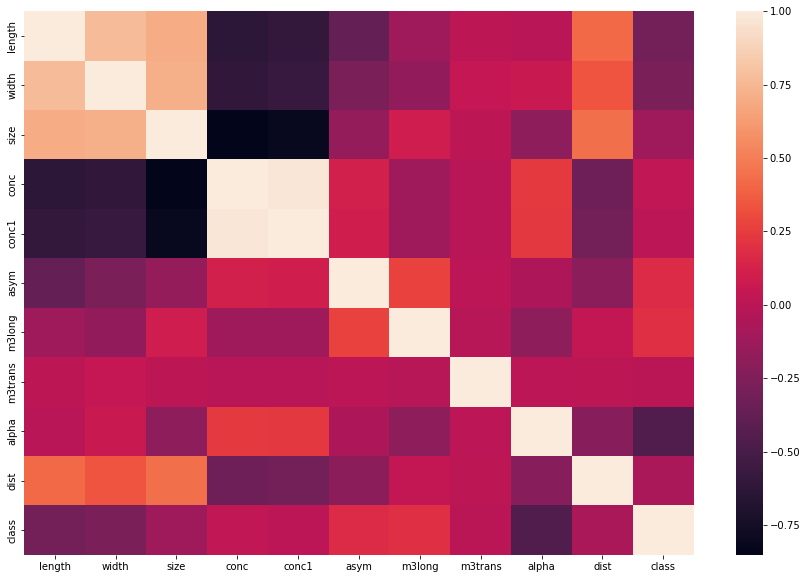

In [8]:
#It seems that some features are highly correlated with one another. It will cause a problem if we are doing linear regression, but since this is a classification problem, multicollinearity will not be an issue. 

plt.figure(figsize=(15,10))
sns.heatmap(corrmap)

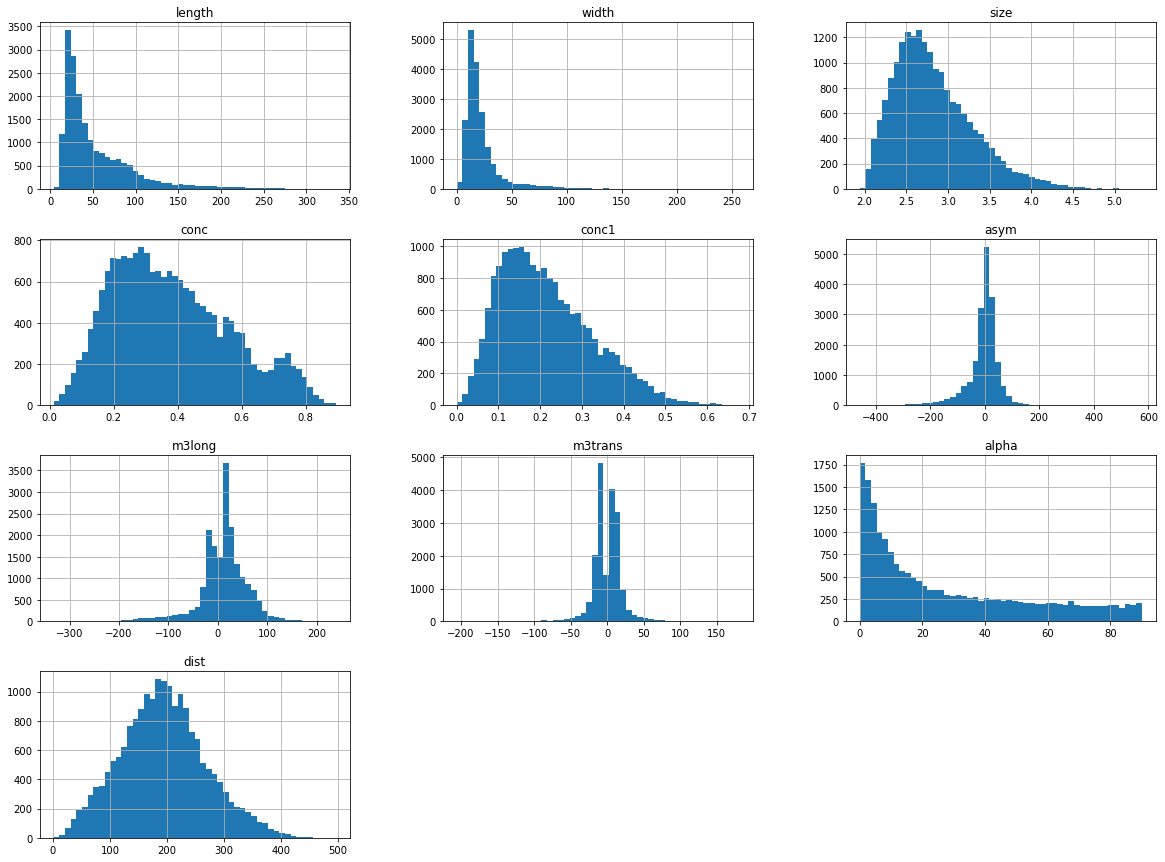

In [9]:
#We can also check the distribution of the values within our features


df.drop('class', axis=1).hist(bins=50,figsize=(20,15));

In [10]:
#Now we need to separate our dataset into a training set and a test set. From this point, we will only look at the training set.

from sklearn.model_selection import train_test_split

X = df.drop('class', axis=1)
y = df['class']

#Since our data is imbalanced, we will have to oversample 0 so that we will have a balanced or mostly balanced dataset. We used oversampling so that no information is lost.
#However, oversampling may lead to overfitting.

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X, y = ros.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
#Now our dataset is balanced.

y.value_counts()

1    12332
0    12332
Name: class, dtype: int64

In [12]:
#We mentioned earlier that we will have to scale the values of our features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit_transform(X_train)

scaler.transform(X_test) #We do not fit the test set to avoid data leakage


array([[ 0.60358491,  0.59782722,  1.75637881, ..., -1.11297178,
        -1.00801692,  2.07363619],
       [ 1.53441639,  0.67713634,  1.11443725, ..., -1.54976024,
         0.20348992,  0.95358538],
       [-0.15916179, -0.32386366, -0.09879259, ..., -0.48270205,
        -0.97341967,  0.5527364 ],
       ...,
       [-0.72854329, -0.63817012, -1.26791639, ..., -0.28477064,
         0.71933304, -1.8257452 ],
       [ 1.005824  ,  0.6367351 ,  0.83433249, ..., -1.07356991,
        -0.84440339,  2.60111295],
       [-0.41748861, -0.3312029 ,  0.11546664, ..., -0.52552377,
        -0.97397101, -0.14456614]])

In [13]:
#Machine learning
#We won't use GridSearchCV on SVC because of slow performance

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score #determine the performance of models
from sklearn.model_selection import cross_val_score #used to compare performance of models

In [14]:
#We define a function that would fit and train the data to our model

xgbc = XGBClassifier()
forest = RandomForestClassifier()
knn= KNeighborsClassifier()
log = LogisticRegression()

def get_metrics(model):
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    
    print('Train Performance')
    print('\n')
    print(confusion_matrix(y_train,train_preds))
    print('\n')
    print(classification_report(y_train,train_preds))
    print('\n')
    print('-----------------------------------------------------------')
    print('Test Performance')
    print('\n')
    print(confusion_matrix(y_test,preds))
    print('\n')
    print(classification_report(y_test,preds))
    print('\n')
    print('Accuracy score is: {:.2f} %'.format(accuracy_score(y_test,preds)*100))
    
    return accuracy_score(y_test,preds)

In [15]:
#Confusion matrix, and classification report of logistic regression model for both training and test set.
#Model is not overfitting.
#Accuracy score is 77.16%

get_metrics(log)

Train Performance


[[6014 2252]
 [1555 6703]]


              precision    recall  f1-score   support

           0       0.79      0.73      0.76      8266
           1       0.75      0.81      0.78      8258

    accuracy                           0.77     16524
   macro avg       0.77      0.77      0.77     16524
weighted avg       0.77      0.77      0.77     16524



-----------------------------------------------------------
Test Performance


[[2967 1099]
 [ 760 3314]]


              precision    recall  f1-score   support

           0       0.80      0.73      0.76      4066
           1       0.75      0.81      0.78      4074

    accuracy                           0.77      8140
   macro avg       0.77      0.77      0.77      8140
weighted avg       0.77      0.77      0.77      8140



Accuracy score is: 77.16 %


0.7716216216216216

In [16]:
#Confusion matrix, and classification report of XGBClassifier model for both training and test set.
#Model is not overfitting.
#Accuracy score is 90.32%

get_metrics(xgbc)

[16:36:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Performance


[[7923  343]
 [ 133 8125]]


              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8266
           1       0.96      0.98      0.97      8258

    accuracy                           0.97     16524
   macro avg       0.97      0.97      0.97     16524
weighted avg       0.97      0.97      0.97     16524



-----------------------------------------------------------
Test Performance


[[3616  450]
 [ 338 3736]]


              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4066
           1       0.89      0.92      0.90      4074

    accuracy                           0

0.9031941031941032

In [17]:
#Confusion matrix, and classification report of random forest classifier model for both training and test set.
#Model looks like it's overfitting. But for random forests, a 100% accuracy score on the training set, doesn't usually mean that the model is overfitting.
#Accuracy score is 92.94%

get_metrics(forest)

Train Performance


[[8266    0]
 [   0 8258]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8266
           1       1.00      1.00      1.00      8258

    accuracy                           1.00     16524
   macro avg       1.00      1.00      1.00     16524
weighted avg       1.00      1.00      1.00     16524



-----------------------------------------------------------
Test Performance


[[3759  307]
 [ 349 3725]]


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4066
           1       0.92      0.91      0.92      4074

    accuracy                           0.92      8140
   macro avg       0.92      0.92      0.92      8140
weighted avg       0.92      0.92      0.92      8140



Accuracy score is: 91.94 %


0.9194103194103194

In [18]:
#Confusion matrix, and classification report of KNN model for both training and test set.

get_metrics(knn)

Train Performance


[[7021 1245]
 [ 970 7288]]


              precision    recall  f1-score   support

           0       0.88      0.85      0.86      8266
           1       0.85      0.88      0.87      8258

    accuracy                           0.87     16524
   macro avg       0.87      0.87      0.87     16524
weighted avg       0.87      0.87      0.87     16524



-----------------------------------------------------------
Test Performance


[[3101  965]
 [ 666 3408]]


              precision    recall  f1-score   support

           0       0.82      0.76      0.79      4066
           1       0.78      0.84      0.81      4074

    accuracy                           0.80      8140
   macro avg       0.80      0.80      0.80      8140
weighted avg       0.80      0.80      0.80      8140



Accuracy score is: 79.96 %


0.7996314496314496

Text(0, 0.5, 'Accuracy Scores')

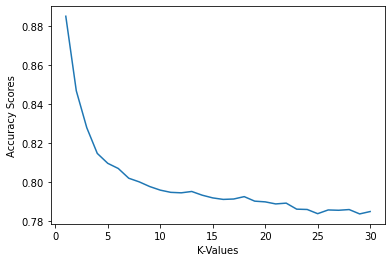

In [19]:
#When using KNN, we must specify the n_neighbors (K-value). We will try to find the optimal K-value first
#For KNN, a higher K-value means a simpler model. We need to find the highest K-value that would maximize our accuracy score.  
#It seems like the best value is at around 2.

k_range = range(1,31)
k_scores = []

for i in  k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(knn,X,y,cv=10,scoring='accuracy')
    k_scores.append(score.mean())
    
plt.plot(k_range,k_scores)
plt.xlabel('K-Values')
plt.ylabel('Accuracy Scores')

In [20]:
#If we set the k-value to 2, we improve the accuracy by approx. 2 pts

knn = KNeighborsClassifier(n_neighbors=2)

get_metrics(knn)

Train Performance


[[8266    0]
 [1351 6907]]


              precision    recall  f1-score   support

           0       0.86      1.00      0.92      8266
           1       1.00      0.84      0.91      8258

    accuracy                           0.92     16524
   macro avg       0.93      0.92      0.92     16524
weighted avg       0.93      0.92      0.92     16524



-----------------------------------------------------------
Test Performance


[[3729  337]
 [1123 2951]]


              precision    recall  f1-score   support

           0       0.77      0.92      0.84      4066
           1       0.90      0.72      0.80      4074

    accuracy                           0.82      8140
   macro avg       0.83      0.82      0.82      8140
weighted avg       0.83      0.82      0.82      8140



Accuracy score is: 82.06 %


0.8206388206388207

In [21]:
#The top two models that produced the best results are the Random Forest Classifier and XGBClassifier
#XGBClassifier is however faster than Random Forest Classifier
#What if we only got 'lucky' due to the random shuffling of data in the train test split?

#One downside to using train test split is the fact that it is random. We may get different results for each split.

#To compare the performance of our models, we will use K-folds cross-validation. Which produces K number of results which can be averaged to produce the mean result.

#We will use this mean result to compare our models

#Cross-validation is, however, K times slower than train test split.
#Instead of splitting the dataset into a training and test set, we will input the whole dataset into the cross-validation.



scores_forest = cross_val_score(forest,X,y, cv=10, scoring='accuracy')
print('Average accuracy score for random forest is: {:.2f} %'.format(scores_forest.mean()*100))
print('\n')
print('Standard deviation is: {:.2f} %'.format(scores_forest.std()*100))

Average accuracy score for random forest is: 93.50 %


Standard deviation is: 2.13 %


In [22]:
scores_xgbc = cross_val_score(XGBClassifier(use_label_encoder=False), X,y, cv=10, scoring='accuracy') 
print('Average accuracy score for XGBClassifier is: {:.2f} %'.format(scores_xgbc.mean()*100))
print('\n')
print('standard deviation is: {:.2f} %'.format(scores_xgbc.std()*100))

[16:38:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [24]:
#We can clearly see that in terms of accurately predicting the classes of the samples, random forest classifier gives better results.

#However, there are instances where we want to know the preformance of a  model to predict the probability of each sample belonging to a class. This is where ROC AUC comes in.

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [47]:
#For XGBClassifier
#The ROC AUC is 0.961 which is good


xgbc = XGBClassifier()

xgbc.fit(X_train,y_train)
xgbc_probs = xgbc.predict_proba(X_test)
xgbc_probs = xgbc_probs[:,1]
xgbc_auc = roc_auc_score(y_test,xgbc_probs)

print('XGBClassifier Prediction AUC: {:.3f}'.format(xgbc1_auc))

[17:51:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier Prediction AUC: 0.961


In [53]:
#For Random Forest Classifier
#The ROC AUC is 0.970 which is even better than the ROC AUC of XGBClassifier

rf = RandomForestClassifier()

rf.fit(X_train,y_train)
rf_probs = rf.predict_proba(X_test)
rf_probs = rf_probs[:,1]
rf_auc = roc_auc_score(y_test,rf_probs)

print('Random Forest Classifier Prediction AUC: {:.3f}'.format(rf_auc))

Random Forest Classifier Prediction AUC: 0.970


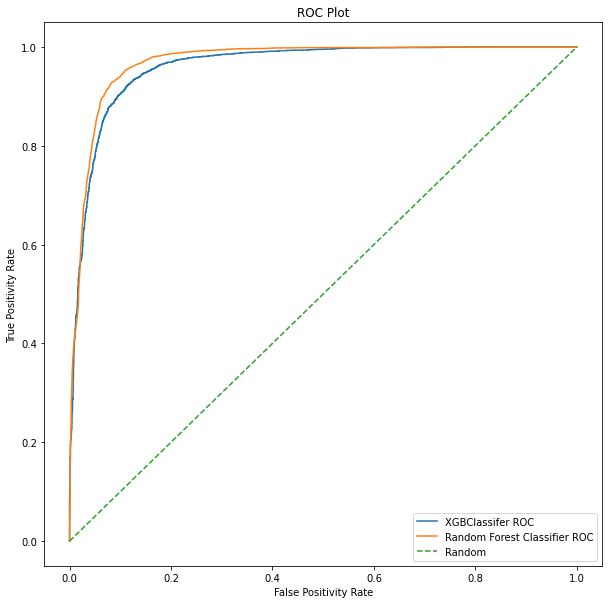

In [56]:
#We plot the ROC of the models
#We can see that the 

r_probs = [0 for _ in range(len(y_test))] #This is just for the random prediction
r_auc = roc_auc_score(y_test,r_probs)
r_fpr,r_tpr,_ = roc_curve(y_test,r_probs)

rf_fpr,rf_tpr,_ = roc_curve(y_test,rf_probs)
x_fpr, x_tpr,_ = roc_curve(y_test,xgbc_probs)

plt.figure(figsize=(10,10))

plt.plot(x_fpr,x_tpr,label='XGBClassifer ROC')
plt.plot(rf_fpr,rf_tpr,label='Random Forest Classifier ROC')
plt.plot(r_fpr,r_tpr,linestyle='--',label='Random')

plt.title('ROC Plot')
plt.xlabel('False Positivity Rate')
plt.ylabel('True Positivity Rate')
plt.legend()

<h2>Conclusion</h2>
<p>In terms of accurately predicting the actual class and the probability of the class of the sample, Random Forest Classifier is the winner!</p>